## LSTM Baseline

In [1]:
# Enable autoreload of local Python modules (e.g., models)
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import numpy as np
import jax
import jax.numpy as jnp
import optax
import time

# local imports
import models.LSTM as models
import util.generation as generation


In [3]:
# initialize the jax random key
key = jax.random.key(0)

# Load data

In [4]:
# load the ./data/text8_train.txt and ./data/text8_test.txt files
with open("./data/text8_train.txt", "r") as f:
    train_text = f.read()
with open("./data/text8_test.txt", "r") as f:
    test_text = f.read()

# print the length of the training text and test text
print(f"Length of training text: {len(train_text):_} characters")
print(f"Length of test text: {len(test_text):_} characters")

Length of training text: 90_000_000 characters
Length of test text: 5_000_000 characters


In [5]:
# Build vocabulary (lowercase + space + a few punctuations)
char_set = list("abcdefghijklmnopqrstuvwxyz ")
char_to_int = {ch:i for i,ch in enumerate(char_set)}
int_to_char = {i:ch for ch,i in char_to_int.items()}


def encode(s):
    """Encode string to array of integers"""
    ids = [char_to_int[c] for c in s]
    return np.array(ids, dtype=np.uint8)  # use np.uint8 to save space

In [6]:
# encode the text
train_text_int = encode(train_text)
test_text_int = encode(test_text)

In [7]:
# sanity check: display a few random characters from the training text
T = 128
for _ in range(5):
    # choose random position in text
    N = np.random.randint(low=0, high=len(train_text)-T)
    print(train_text[N:N+T])
    print()

 be assumed to have never possessed an umbilical cord gosse postulated that adam did have a navel because it is how humans are f

ith john heartfield developed the technique of photomontage during this period the artists published a series of short lived pol

 documentation center at the university of texas at austin evolution the evolution of the indo european languages by dr c george

n was a major trading town and ships traders and missionaries went from there to many different locations the earlier archbishop

and lost a final set tie breaker nine seven after that match he retired from the tour for good and confined himself to playing o



# Create a basic LSTM model

In [8]:
def create_train_state(rng, vocab_size=27, hidden_size=256, n_layers=2, dropout=0.1, max_len=128):
    # create a basic LSTM model
    model = models.CharLSTM(
        vocab_size, 
        hidden_size,
        n_layers,
        dropout,
        max_len,
    )
    # create a dummy input for initialization
    dummy = jnp.zeros((1, min(16, max_len)), dtype=jnp.int32)
    # pass the dummy input to the model to initialize the parameters
    params = model.init({"params": rng, 'dropout': rng}, dummy, train=True)["params"]
    return model, params

In [9]:
# vocab size
vocab_size = len(char_set)

# internal model dimensions
# d_model = 256
# dimension of the hidden state in LSTM
hidden_size=256

# number of attention heads
n_heads = 8

# number of LSTM layers: 1-3 layers are common for LSTM
n_layers = 2

# maximum sequence length
max_len = 128

# dropout rate between LSTM layers
dropout=0.1

model, params = create_train_state(key, vocab_size, hidden_size, n_layers, dropout, max_len)

2025-10-28 11:22:45.986289: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.


In [10]:
# compute the number of parameters
def count_params(params):
    return sum(x.size for x in jax.tree_util.tree_leaves(params))


print(f"Number of parameters: {count_params(params):_}")

Number of parameters: 1_064_448


In [11]:
# sanity check: create a batch of data & run a forward pass
B, T = 4, 32
batch = jax.random.randint(
    key=key,
    shape=(B, T), minval=0, maxval=len(char_set))
logits = model.apply({"params": params}, batch, train=False)

print("batch shape:", batch.shape)  # (B, T)
print("logits shape:", logits.shape)  # (B, T, vocab_size)

2025-10-28 11:22:48.083117: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.


batch shape: (4, 32)
logits shape: (4, 32, 27)


# Loss function

In [12]:
@jax.jit
def loss_and_metrics(logits, targets):
    """Compute cross-entropy loss and accuracy.

    Assumes `targets` contains only valid integer class ids in [0, V-1] (no -1 ignore tokens).

    Args:
      logits: (B, T, V) float array of unnormalized scores.
      targets: (B, T) integer array with ground-truth class ids.

    Returns:
      loss: scalar average cross-entropy over all positions.
      metrics: dict with keys "loss" and "acc" (both scalars).
    """
    # Flatten batch/time dims so optax works on shape (N, V) and (N,)
    vocab = logits.shape[-1]
    flat_logits = logits.reshape(-1, vocab)
    flat_targets = targets.reshape(-1)

    # Per-position cross-entropy, then mean over all positions
    per_pos = optax.softmax_cross_entropy_with_integer_labels(flat_logits, flat_targets)
    loss = per_pos.mean()

    # prediction over all positions
    preds = jnp.argmax(logits, axis=-1)  # (B, T)

    # compute accuracy over only the last position
    is_match = preds == targets

    # Accuracy over all positions
    acc_all = jnp.mean(is_match.astype(jnp.float32))

    # Accuracy over only last position
    acc_last = jnp.mean(is_match.astype(jnp.float32)[:,-1])

    return loss, {"loss": loss, "acc": acc_all, "acc_last": acc_last}

# Optimization step:

In [13]:
# create an update function
def train_step(params, step_rng, opt_state, x, y, tx):
    """Single optimization step using optax optimizer.

    Args:
      params: pytree of model parameters.
      opt_state: optax optimizer state corresponding to `params`.
      x: (B, T) int array input tokens.
      y: (B, T) int array target tokens.
      tx: optax.GradientTransformation (already initialized).

    Returns:
      new_params: updated parameters after one gradient step.
      new_opt_state: updated optimizer state.
      metrics: dict of scalar metrics (loss, acc).
    """
    def loss_fn(params):
        logits = model.apply({"params": params}, x, train=True, rngs={"dropout": step_rng})
        loss, metrics = loss_and_metrics(logits, y)
        return loss, metrics

    # compute gradients (loss is scalar, metrics is auxiliary)
    (loss, metrics), grads = jax.value_and_grad(loss_fn, has_aux=True)(params)

    # optax update: compute parameter updates and new optimizer state
    updates, new_opt_state = tx.update(grads, opt_state, params)
    new_params = optax.apply_updates(params, updates)
    return new_params, new_opt_state, metrics


# jit: last argument should be static because it is an object
train_step = jax.jit(train_step, static_argnames=("tx",))

# Batch creation:

In [14]:
# create a batch from the training data
def get_batch(text_int, B, T):
    """Create a random batch of data from text_int.

    Args:
      text_int: 1D array of token ids.
      B: batch size (number of sequences).
      T: sequence length (number of tokens per sequence).

    Returns:
      x: (B, T) int array input tokens.
      y: (B, T) int array target tokens.
    """
    # choose random starting indices for each sequence in the batch
    ix = np.random.randint(0, len(text_int) - T, size=B)
    # inputs are text from i to i+T
    x = np.stack([text_int[i:i+T] for i in ix])
    # targets are text from i+1 to i+T+1
    y = np.stack([text_int[i+1:i+T+1] for i in ix])
    return jnp.array(x, dtype=jnp.int32), jnp.array(y, dtype=jnp.int32)

# Optimizer creation:

In [15]:
niter = 100_000
B, T = 128, 32
warmup_steps = 1_000
decay_steps = max(1, niter - warmup_steps)

# define optax optimizer
learning_rate = 0.001

lr_schedule = optax.warmup_cosine_decay_schedule(
    init_value=0.0,
    peak_value=learning_rate,
    warmup_steps=warmup_steps,
    decay_steps=decay_steps,
    end_value=0.0,
)

# Create Adam optimizer (Optax)
# tx = optax.adam(learning_rate=learning_rate)
tx = optax.chain(
    optax.clip_by_global_norm(1.0),    # Optional gradient clipping
    optax.adamw(
        learning_rate=lr_schedule,     # ← Use schedule here
        b1=0.9,
        b2=0.95,
        eps=1e-8,
        weight_decay=0.1,
    ),
)
# Initialize optimizer state for current params
opt_state = tx.init(params)
print(f"Initialized optimizer: Adam lr={learning_rate}")


Initialized optimizer: Adam lr=0.001


In [16]:
loss_history = []
time_history = []
time_test_history = []
loss_test_history = []
time_start = time.time()
for it in range(niter):
    key, step_key = jax.random.split(key)
    batch = get_batch(train_text_int, B, T)
    input, target = batch[0], batch[1]
    params_new, opt_state_new, metrics = train_step(params, step_key, opt_state, input, target, tx)

    # update params and opt_state
    params = params_new
    opt_state = opt_state_new
    acc = metrics['acc']
    acc_last = metrics['acc_last']
    loss = metrics['loss']

    loss_history.append(loss)
    time_history.append(time.time() - time_start)

    if it % (niter // 50) == 0 or it == niter - 1:
        time_since_start = time.time() - time_start
        # compute loss on test set
        B_test, T_test = 1024, 32
        test_batch = get_batch(test_text_int, B_test, T_test)
        test_input, test_target = test_batch[0], test_batch[1]
        test_logits = model.apply({"params": params}, test_input, train=False)
        test_loss, test_metrics = loss_and_metrics(test_logits, test_target)
        test_acc = test_metrics['acc']
        test_acc_last = test_metrics['acc_last']
        loss_test_history.append(test_loss)
        time_test_history.append(time_since_start)
        print(f"iteration {it:_}  time: {time_since_start:.1f} seconds")
        print(f"\t \t loss(train :: test): {loss:.4f} :: {test_loss:.4f}")
        print(f"\t \t accuracy (train :: test): {100*acc:.1f}% :: {100*test_acc:.1f}%")
        print(f"\t \t accuracy (last character) (train :: test): {100*acc_last:.1f}% :: {100*test_acc_last:.1f}%")
        print()


iteration 0  time: 3.5 seconds
	 	 loss(train :: test): 3.2965 :: 3.2969
	 	 accuracy (train :: test): 3.7% :: 3.2%
	 	 accuracy (last character) (train :: test): 2.3% :: 2.8%

iteration 2_000  time: 15.8 seconds
	 	 loss(train :: test): 1.4777 :: 1.5202
	 	 accuracy (train :: test): 54.8% :: 53.5%
	 	 accuracy (last character) (train :: test): 43.0% :: 56.6%

iteration 4_000  time: 26.8 seconds
	 	 loss(train :: test): 1.3778 :: 1.4267
	 	 accuracy (train :: test): 56.9% :: 55.7%
	 	 accuracy (last character) (train :: test): 57.0% :: 57.5%

iteration 6_000  time: 37.9 seconds
	 	 loss(train :: test): 1.3944 :: 1.4248
	 	 accuracy (train :: test): 56.2% :: 56.2%
	 	 accuracy (last character) (train :: test): 61.7% :: 60.1%

iteration 8_000  time: 49.0 seconds
	 	 loss(train :: test): 1.3725 :: 1.3824
	 	 accuracy (train :: test): 57.1% :: 56.8%
	 	 accuracy (last character) (train :: test): 57.0% :: 58.9%

iteration 10_000  time: 60.2 seconds
	 	 loss(train :: test): 1.3408 :: 1.3651


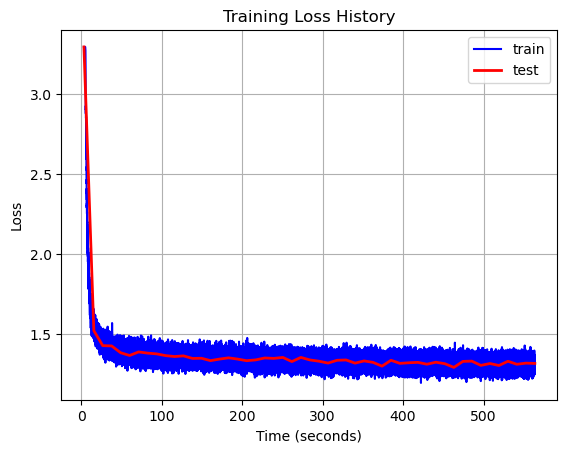

In [17]:
# plot the loss history
import matplotlib.pyplot as plt
plt.plot(time_history, loss_history, '-', label='train', color="blue")
plt.plot(time_test_history, loss_test_history, '-', label='test', lw=2, color="red")
plt.xlabel("Time (seconds)")
plt.ylabel("Loss")
plt.legend(loc='upper right')
plt.title("Training Loss History")
plt.grid()

In [18]:
B = 1
seed = 42
rng = jax.random.PRNGKey(seed)
prompt = "hello my fri"
# prompt_int = encode(prompt.lower())
prompt_int = jnp.array([[char_to_int.get(c, len(char_set)) for c in prompt.lower()[:64]]], dtype=jnp.int32)

gen_len = 1000
out_ids = generation.generate_tokens(model, params, rng, prompt_int, gen_len, block_size=64,
                          temperature=0.7, sample=True)
print('generated ids shape:', out_ids.shape)
print('generated text:')
generated_text = ''.join(int_to_char.get(int(x), '?') for x in list(out_ids[0]))
# concatenate with prompt
print(prompt + generated_text)
# print(''.join(int_to_char.get(int(x), '?') for x in list(out_ids[0])))

2025-10-28 11:32:21.196341: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.


generated ids shape: (1, 1000)
generated text:
hello my friend also workers of holiday in languages because of the control of cape s problems like the empire was a media agency river skill at its computer structures were able to serve as a strong political proportion of the result of the president in the relection argue than only greek conservation began to control office and the island see also the american assisted the drug in games such as simulation has occasionally expanded by the personal indicating the city of diman s life of the population for the original confirmed function in the computer revolution of the right the red computer scryptory release this is the most produced by the sane arabian bacon and is like the straight of the same race the number of functional strong content of the particles has been granted in the end of the particular states of berlin or petroleum of aryan new year the objects of his constitutional war and in one nine nine four the republic of milos fran